https://qiita.com/li-li-qiita/items/ae871d4093d3d83d974d

# Adversarial Variational Bayes toy example
[Yusuke Hayashi](https://github.com/hayashiyus)<br/>
June 10, 2019 <br/>

This notebook implements the toy example from:<br/>
[Adversarial Variational Bayes: Unifying Variational Autoencoders and Generative Adversarial Networks](https://arxiv.org/abs/1701.04722)<br/>
Lars Mescheder, Sebastian Nowozin, Andreas Geiger

See this [blog post](http://www.inference.vc/variational-inference-with-implicit-models-part-ii-amortised-inference-2/) for another derivaiton and implementation of this approach. 

## Variational inference
Given samples $x$ from an unobserved data density $q(x)$, we are interested in building a latent-variable generative model $p(x, z)$ such that $p(x)$ is close to $q(x)$. This is a difficult problem as evaluating the density under the model, $p(x)$ requires evaluating an intractable integral over the unobserved latent variable $z$: $p(x)=\int \text{d}z \;p(x, z)$.

Variational inference bypasses this problem by optimizing a lower bound on the log-likelihood of the data:
$$\log p(x) \ge -\text{KL}\left(q(z|x) \| p(z)\right) + \mathbb{E}_{q(z|x)}\left[\log p(x|z)\right]$$
This lower bound depends on an additional distribution, $q(z|x)$ which is known as the _variational distribution_ and acts as an approximation to the true posterior $p(z|x)$. 
To evaluate and learn using the variational lower bound, we need to be able to draw samples from the _variational distribution_ and to evaluate the density of a sample from the _variational distribution_. This typically restricts the family of variational distributions to those with known or tractable densities (e.g. factorial Gaussian, normalizing flows).

## Variational inference with intractable densities
For many models we care about, such as models that exhibit [explaining away](http://www.inference.vc/variational-inference-with-implicit-models-part-ii-amortised-inference-2/), the true posterior distribution is complex and multimodal. Appropriately training these models with variational inference thus requires a rich variational family. One way of generating such complex variatonal families is to use neural networks! Here we will use an implicit posterior to generate samples $z=z_\phi(x, \epsilon$) where $\epsilon \sim \mathcal{N}(0, I)$ and $x$ is the observed data. If $z_\phi$ is a complex neural network, then we can use it to draw samples from any distribution. However, we no longer know how to evaluate the density of $z$, $q(z|x)$ and thus can't compute the $\text{KL}(q(z|x) \| p(z))$ term in the variational lower bound.

The approach taken by adversarial variational bayes is to introduce a discriminator that can approximate the intractable $\text{KL}$ term in the variatonal lower bound. This discriminator is trained to classify between samples $(x, z_\text{prior})$ where $z_\text{prior} \sim p(z)$ and $(x, z_\phi(x, \epsilon))$ where $z_\phi$ is our neural network that approximates the posterior. They show that at convergence, the optimal disriminator $T^*(x, z)$ is equal to $\log q(z|x) - \log p(z)$, the missing intractable term needed to compute the $\text{KL}$ term! In practice, we don't have access to the optimal discriminator so we'll plug in our current best estimate, $T(x, z)$.

The objective optimized by the generative model, $p(x, z)$ and inference network, $z_\phi$ is:
$$\underset{p, \phi}{\max} \mathbb{E}_{x\sim q(x)}\left[\mathbb{E}_\epsilon\left[-T(x, z_\phi(x, \epsilon)) + \log p(x\;|\;z_\phi(x, \epsilon)\right]\right]$$
and the discriminator is trained to minimize the normal GAN loss, but using $z$ sampled from the prior or posterior:
$$\underset{T}{\min}\mathbb{E}_{x\sim q(x)}\left[\mathbb{E}_{\epsilon}\left[\log \sigma\left(T(x, z_\phi(x, \epsilon)\right)\right] + 
\mathbb{E}_{z \sim p(z)}\left[\log\left(1 - \sigma\left(T(x, z)\right)\right)\right]\right]
$$

## Implementation details
We trained an AVB model on the dataset of 4 points used in the paper. Each datapoint is a 4-dimensional binary vector with one non-zero component. For all the inference, generative, and discriminator networks we used neural networks with 2 hidden layers of 256 hidden units.

Send questions/comments/bugs to [@hayashiyus](https://twitter.com/hayashiyus).

## Setup

In [1]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.contrib.slim as slim
from tensorflow_probability import edward2 as ed
import matplotlib
import matplotlib.cm as cm
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
plt.style.use('seaborn-colorblind')
#rcParams['figure.figsize'] = 16, 4
%matplotlib inline
%load_ext autotime

# function shorthand 
tfc = tf.contrib
tfd = tfp.distributions
graph_replace = tfc.graph_editor.graph_replace


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Parameters

In [2]:
batch_size = 512 
latent_dim = 2 # dimension of latent space
input_dim = 4 # dimension of input data
n_layer = 2  # number of hidden layers 
n_unit = 256  # number of hidden units 

time: 484 µs


## Create dataset of one-hot vectors

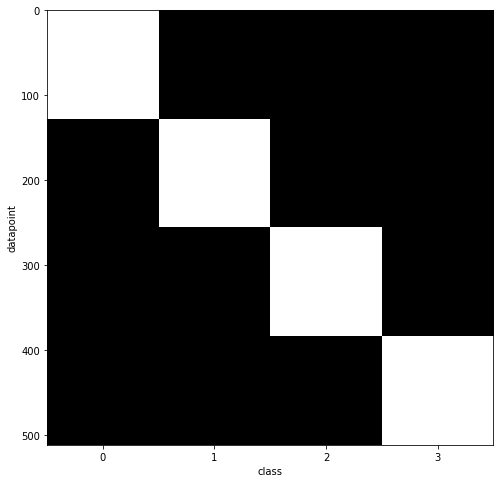

time: 196 ms


In [3]:
# number of data for each class; here we have 4 classes
points_per_class = batch_size / input_dim
# create labels for the 4 classes
labels = np.concatenate([[i] * int(points_per_class) 
                        for i in range(input_dim)])
# create dataset
np_data = np.eye(input_dim, dtype=np.float32)[labels]
rcParams['figure.figsize'] = 8, 8
plt.imshow(np_data, interpolation='nearest', aspect='auto', cmap=cm.gray)
plt.xticks(range(input_dim))
plt.xlabel('class')
plt.ylabel('datapoint')
plt.show()

## Network definitions

In [4]:
x = tf.constant(np_data)

#Encoder
Gauss4D = tfd.MultivariateNormalDiag(loc=tf.zeros(input_dim),
                                     scale_diag=tf.ones(input_dim))
noise = Gauss4D.sample(batch_size)

with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
    enc = tf.concat([x, noise], 1)  # concatenate input data and noise
    enc = tfc.layers.repeat(enc, n_layer, tfc.layers.fully_connected, n_unit)
    enc = tfc.layers.fully_connected(enc, latent_dim, activation_fn = None)
    
#Decoder
with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):    
    dec = tfc.layers.repeat(enc, n_layer, tfc.layers.fully_connected, n_unit)
    # clipping is necessary to prevent NaN when dec is too large 
    dec = 1e-6 + (1 - 2e-6) * tfc.layers.fully_connected(dec, input_dim,
                                                   activation_fn = tf.nn.sigmoid)
    # calculate log_probability in Bernoulli distribution
    log_probs = tfd.Bernoulli(probs=dec).log_prob(x)

#Discriminator
Gauss2D = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_dim),
                                     scale_diag=tf.ones(latent_dim))
prior = Gauss2D.sample(batch_size)

dis_pr = tf.concat([2*x-1, prior], 1)
dis_po = tf.concat([2*x-1, enc], 1)
with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
    dis = tfc.layers.repeat(dis_pr, n_layer, 
                           tfc.layers.fully_connected, n_unit)
    log_d_prior = tfc.layers.fully_connected(dis, 1, activation_fn = None)

    # use graph_replace to reuse the same network
    dis2 = graph_replace(dis, {dis_pr: dis_po})
    log_d_posterior = graph_replace(log_d_prior, {dis: dis2})
    
#Loss functions
#disctiminator loss
disc_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                        logits = log_d_posterior, 
                        labels = tf.ones_like(log_d_posterior)) +
                tf.nn.sigmoid_cross_entropy_with_logits(
                        logits = log_d_prior, 
                        labels = tf.zeros_like(log_d_prior)))

# decoder loss
recon_likelihood = tf.reduce_sum(log_probs, axis=1)
# generator loss
gen_loss = tf.reduce_mean(log_d_posterior) - tf.reduce_mean(recon_likelihood)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.
time: 225 ms


## Construct model and training ops

In [5]:
qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "decoder")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

opt = tf.train.AdamOptimizer(2e-4, beta1=0.5)
opt2 = tf.train.AdamOptimizer(1e-3, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list = qvars + pvars)
train_disc_op = opt2.minimize(disc_loss, var_list = dvars)

Instructions for updating:
Use tf.cast instead.
time: 462 ms


In [6]:
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
sess = tf.Session()
sess.run(init_g)
sess.run(init_l)

time: 117 ms


## Train model

In [7]:
gen_loss_list = []
disc_loss_list = []
n_epoch = 2000
for i in tqdm(range(n_epoch)):
    gl, dl, _, _ = sess.run([gen_loss, disc_loss, train_gen_op, train_disc_op])
    gen_loss_list.append(gl)
    disc_loss_list.append(dl)

100%|██████████| 2000/2000 [00:18<00:00, 108.74it/s]

time: 18.4 s


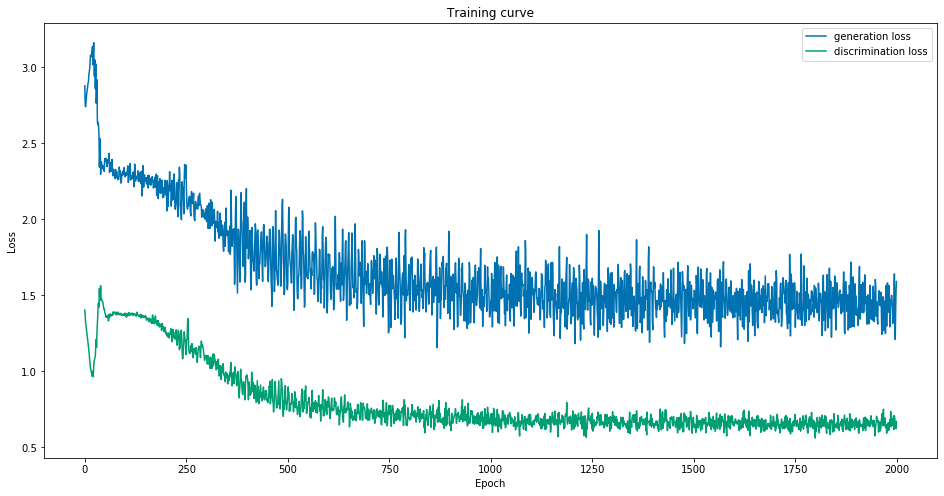

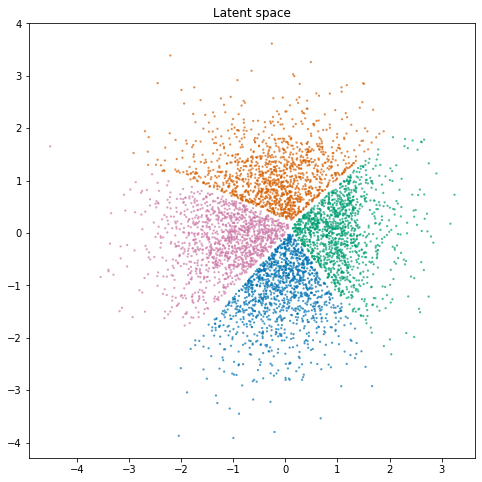

time: 771 ms


In [8]:
rcParams['figure.figsize'] = 16, 8
plt.figure()
plt.plot(np.arange(n_epoch), np.asarray(gen_loss_list))
plt.plot(np.arange(n_epoch), np.asarray(disc_loss_list))
plt.legend(['generation loss','discrimination loss'])
plt.title('Training curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

n_vis = 10
enc_test = np.vstack([sess.run(enc) for _ in range(n_vis)])
enc_test_label = np.tile(labels, (n_vis))
rcParams['figure.figsize'] = 8, 8
plt.figure()
for i in range(len(np.unique(labels))):
    plt.scatter(enc_test[enc_test_label==i, 0], enc_test[enc_test_label==i, 1], 
                edgecolor='none', alpha=0.7, s=5)
plt.title('Latent space')
plt.show()